In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
%matplotlib inline

In [2]:
def mv(a, n=20) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [3]:
class Config():
    def __init__(self, nS, nA):
        self.Vmin = -0.1
        self.Vmax = 1.1
        self.nAtoms = 51
        self.nS = nS
        self.nA = nA
        self.gamma = 0.99

In [4]:
class C51():
    def __init__(self, config):
        self.config = config
        self.p = np.ones((self.config.nS, self.config.nA,\
                        self.config.nAtoms)) * 1.0/self.config.nAtoms
        self.p[:, :, 0] = 10
        for x in range(self.config.nS):
            for a in range(self.config.nA):
                self.p[x, a, :] /= np.sum(self.p[x, a, :])
        self.dz = (self.config.Vmax - self.config.Vmin)/(self.config.nAtoms-1)
        self.z = np.arange(self.config.nAtoms) * self.dz + self.config.Vmin
    def observe(self, x, a, r, nx, terminal, alpha):
        Q_nx = np.zeros(self.config.nA)
        for at in range(self.config.nA):
            Q_nx[at] = np.sum(self.p[nx, at, :] * self.z)
        a_star = np.argmax(Q_nx)
        m = np.zeros(self.config.nAtoms)
        for i in range(self.config.nAtoms):
            if not terminal:
                tz = np.clip(r + self.config.gamma*self.z[i],\
                        self.config.Vmin, self.config.Vmax)
            else:
                tz = np.clip(r,\
                        self.config.Vmin, self.config.Vmax)
            b = (tz - self.config.Vmin)/self.dz
            l = int(np.floor(b)); u = int(np.ceil(b))
            m[l] += self.p[nx, a_star,i] * (u-b)
            m[u] += self.p[nx, a_star,i] * (b-l)
        self.p[x, a, :] = self.p[x, a, :] + alpha * (m - self.p[x, a, :]) ##### How ####
        self.p[x, a, :] /= np.sum(self.p[x, a, :])
    def Q(self, x):
        Q_nx = np.zeros(self.config.nA)
        for at in range(self.config.nA):
            Q_nx[at] = np.sum(self.p[x, at, :] * self.z)
        return Q_nx
    def CVaR(self, x, alpha, N=20):
        Q = np.zeros(self.config.nA)
        for a in range(self.config.nA):
            values = np.zeros(N)
            for n in range(N):
                tau = np.random.uniform(0, alpha)
                idx = np.argmax((np.cumsum(c51.p[x, a, :]) > tau) * 1.0)
                z = self.z[idx]
                values[n] = z
            Q[a] = np.mean(values)
        return Q
    def plot(self, x, a):
        plt.plot(self.z, self.p[x, a, :], '.')

In [5]:
class Qlearning():
    def __init__(self, config):
        self.config = config
        self.Q = np.zeros((self.config.nS, self.config.nA))
    def observe(self, x, a, r, nx, alpha):
        self.Q[x, a] = self.Q[x, a] + alpha * \
        (r + self.config.gamma * np.max(self.Q[nx, :]) - self.Q[x, a])

In [615]:
env = gym.make('FrozenLake-v0')
config = Config(env.observation_space.n, env.action_space.n)
c51 = C51(config)
q = Qlearning(config)

num_episode = 5000
returns = np.zeros(num_episode)
for ep in range(num_episode):
    terminal = False
    e = max(0.1, 0.9 + ep * ((0 - 0.9)/(num_episode)))
    alpha = max(0.001, 0.5 + ep * ((0.4 - 0.5)/(num_episode/5)))
    o = env.reset()
    ret = 0
    while not terminal:
        if np.random.rand()<= e:
            a = np.random.randint(env.action_space.n)
        else:
            a = np.argmax(c51.Q(o))
            #a = np.argmax(c51.CVaR(o, alpha=0.25, N=50))
            #a = np.argmax(q.Q[o, :])
        no, r, terminal, _ = env.step(a) 
        ret += r
        c51.observe(o, a, r, no, terminal, alpha)
        q.observe(o, a, r, no, alpha)
        o = no
    returns[ep] = ret

Text(0,0.5,'Return')

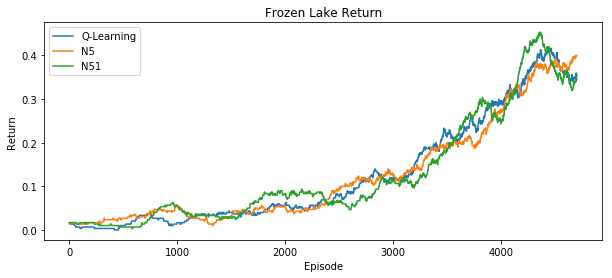

In [619]:
plt.figure(figsize=(10, 4))
plt.title('Frozen Lake Return')
plt.plot(mv(np.load('q.npy'), 300), label = 'Q-Learning')
plt.plot(mv(np.load('qC51N5.npy'), 300), label = 'N5')
plt.plot(mv(np.load('qC51N51.npy'), 300), label = 'N51')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Return')

Text(0,0.5,'Prob')

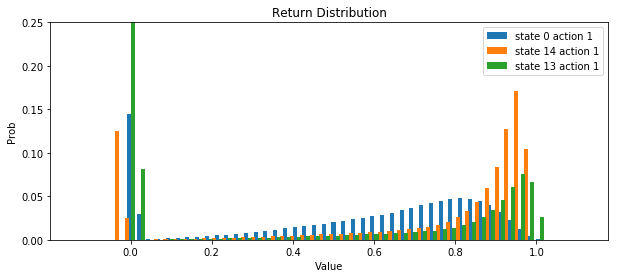

In [545]:
plt.figure(figsize=(10, 4))
plt.title('Return Distribution')
plt.bar(c51.z, c51.p[0, 0, :], width = 0.01, label = 'state 0 action 1', linewidth = 5)
plt.bar(c51.z - 0.03, c51.p[14, 0, :], width = 0.01, label = 'state 14 action 1', linewidth = 5)
plt.bar(c51.z + 0.01, c51.p[13, 0, :], width = 0.01, label = 'state 13 action 1', linewidth = 5)
plt.ylim([0, 0.25])
plt.legend()
plt.xlabel('Value')
plt.ylabel('Prob')

In [610]:
### Running the same thing with CVaR action selection

In [620]:
### We need a new envinronemnt for CVaR, since the forzen lake is not okay! ###

In [6]:
from cliffwalker import *

In [81]:
env = GridWorld(5, 5, random_action_p=0.3)
config = Config(env.nS, env.nA)
config.Vmin = -30; config.Vmax = -2; config.gamma = 0.99; config.nAtoms=51
c51 = C51(config)
q = Qlearning(config)

num_episode = 2500
returns = np.zeros(num_episode)
for ep in range(num_episode):
    terminal = False
    e = max(0.05, 1 + ep * ((0 - 9)/(num_episode)))
    alpha = max(0.001, 0.9 + ep * ((0 - 0.9)/(num_episode)))
    o = env.reset()
    ret = 0
    while not terminal:
        if np.random.rand()<= e:
            a = np.random.randint(env.nA)
        else:
            a = np.argmax(c51.Q(o))
            #a = np.argmax(c51.CVaR(o, alpha=0.25, N=50))
            #a = np.argmax(q.Q[o, :])
        no, r, terminal = env.step(a) 
        ret += r
        c51.observe(o, a, r, no, terminal, alpha)
        #q.observe(o, a, (r/100)+1, no, alpha)
        o = no
    returns[ep] = ret

In [149]:
np.save('cliffwalkerQlearning.npy', returns)

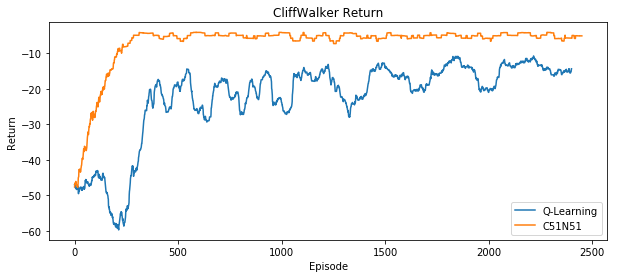

In [82]:
plt.figure(figsize=(10, 4))
plt.title('CliffWalker Return')
plt.plot(mv(np.load('cliffwalkerQlearning.npy'), 100), label = 'Q-Learning')
#plt.plot(mv(np.load('cliffwalkerC51N51q.npy'), 200), label = 'C51N51')
plt.plot(mv(returns, 50), label = 'C51N51')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Return');

Text(0,0.5,'Prob')

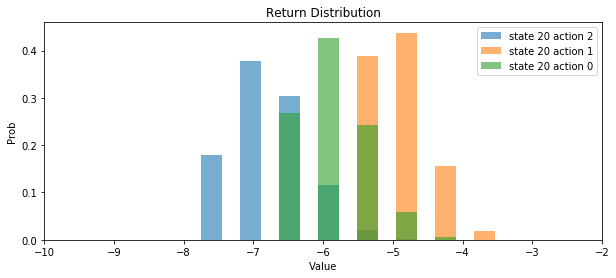

In [84]:
plt.figure(figsize=(10, 4))
plt.title('Return Distribution')
plt.bar(c51.z, c51.p[20, 2, :], width=0.3, label = 'state 20 action 2', linewidth = 5, alpha=0.6)
plt.bar(c51.z, c51.p[20, 1, :], width=0.3, label = 'state 20 action 1', linewidth = 5, alpha=0.6)
plt.bar(c51.z, c51.p[20, 0, :], width=0.3, label = 'state 20 action 0', linewidth = 5, alpha=0.6)
plt.legend()
plt.xlim([-10, -2])
plt.xlabel('Value')
plt.ylabel('Prob')

Text(0,0.5,'Prob')

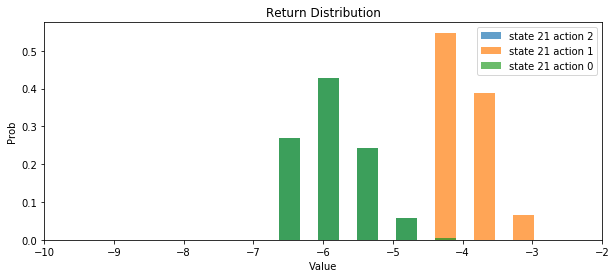

In [85]:
plt.figure(figsize=(10, 4))
plt.title('Return Distribution')
plt.bar(c51.z, c51.p[21, 2, :], width=0.3, label = 'state 21 action 2', linewidth = 5, alpha=0.7)
plt.bar(c51.z, c51.p[21, 1, :], width=0.3, label = 'state 21 action 1', linewidth = 5, alpha=0.7)
plt.bar(c51.z, c51.p[21, 0, :], width=0.3, label = 'state 21 action 0', linewidth = 5, alpha=0.7)
plt.legend()
plt.xlim([-10, -2])
plt.xlabel('Value')
plt.ylabel('Prob')

Text(0,0.5,'Prob')

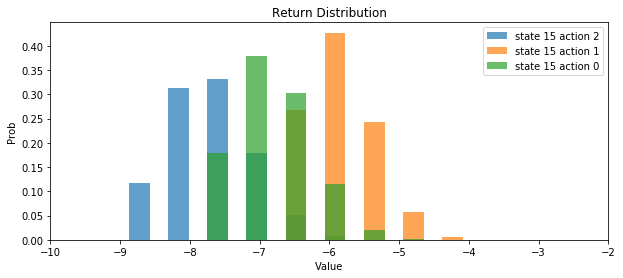

In [86]:
plt.figure(figsize=(10, 4))
plt.title('Return Distribution')
plt.bar(c51.z, c51.p[15, 2, :], width=0.3, label = 'state 15 action 2', linewidth = 5, alpha=0.7)
plt.bar(c51.z, c51.p[15, 1, :], width=0.3, label = 'state 15 action 1', linewidth = 5, alpha=0.7)
plt.bar(c51.z, c51.p[15, 0, :], width=0.3, label = 'state 15 action 0', linewidth = 5, alpha=0.7)
plt.legend()
plt.xlim([-10, -2])
plt.xlabel('Value')
plt.ylabel('Prob')

(30, 50)

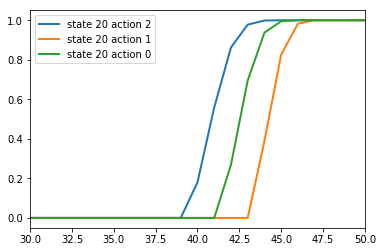

In [87]:
plt.plot(np.cumsum(c51.p[20, 2, :]), label = 'state 20 action 2', linewidth = 2)
plt.plot(np.cumsum(c51.p[20, 1, :]), label = 'state 20 action 1', linewidth = 2)
plt.plot(np.cumsum(c51.p[20, 0, :]), label = 'state 20 action 0', linewidth = 2)
plt.legend()
plt.xlim([30, 50])

In [88]:
### Running the same thing with CVaR action selection

In [13]:
env = GridWorld(10, 15, random_action_p=0.3)
config = Config(env.nS, env.nA)
config.Vmin = -30; config.Vmax = -2; config.gamma = 0.99; config.nAtoms=51
c51 = C51(config)
q = Qlearning(config)

num_episode = 5000
returns = np.zeros(num_episode)
for ep in range(num_episode):
    terminal = False
    e = max(0.05, 1 + ep * ((0 - 9)/(num_episode)))
    alpha = max(0.001, 0.9 + ep * ((0 - 0.9)/(num_episode)))
    o = env.reset()
    ret = 0
    while not terminal:
        if np.random.rand()<= e:
            a = np.random.randint(env.nA)
        else:
            a = np.argmax(c51.Q(o))
            #a = np.argmax(c51.CVaR(o, alpha=0.25, N=50))
            #a = np.argmax(q.Q[o, :])
        no, r, terminal = env.step(a) 
        ret += r
        c51.observe(o, a, r, no, terminal, alpha)
        #q.observe(o, a, (r/100)+1, no, alpha)
        o = no
    returns[ep] = ret

Text(0,0.5,'Prob')

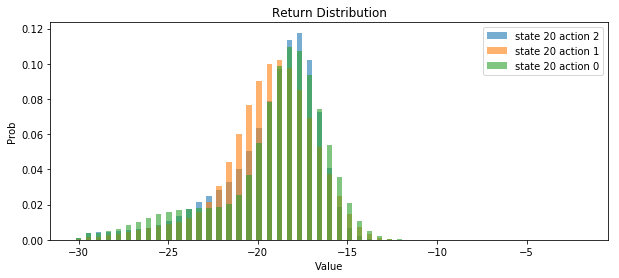

In [15]:
plt.figure(figsize=(10, 4))
plt.title('Return Distribution')
plt.bar(c51.z, c51.p[20, 2, :], width=0.3, label = 'state 20 action 2', linewidth = 5, alpha=0.6)
plt.bar(c51.z, c51.p[20, 1, :], width=0.3, label = 'state 20 action 1', linewidth = 5, alpha=0.6)
plt.bar(c51.z, c51.p[20, 0, :], width=0.3, label = 'state 20 action 0', linewidth = 5, alpha=0.6)
plt.legend()
#plt.xlim([-10, -2])
plt.xlabel('Value')
plt.ylabel('Prob')

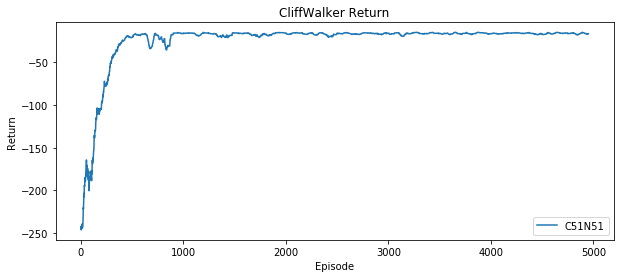

In [16]:
plt.figure(figsize=(10, 4))
plt.title('CliffWalker Return')
plt.plot(mv(returns, 50), label = 'C51N51')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Return');

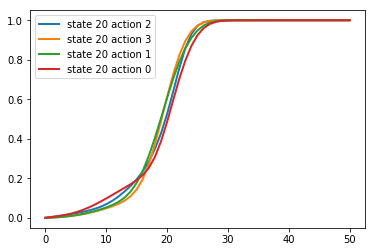

In [27]:
plt.plot(np.cumsum(c51.p[20, 2, :]), label = 'state 20 action 2', linewidth = 2)
plt.plot(np.cumsum(c51.p[20, 3, :]), label = 'state 20 action 3', linewidth = 2)
plt.plot(np.cumsum(c51.p[20, 1, :]), label = 'state 20 action 1', linewidth = 2)
plt.plot(np.cumsum(c51.p[20, 0, :]), label = 'state 20 action 0', linewidth = 2)
plt.xlim([])
plt.legend()

In [26]:
print(c51.CVaR(20, 0.1))

[-25.716 -25.352 -25.8   -24.4  ]
